#**Universidad Galileo**
##Statistical Learning II Tarea No 2
###César Luis Polanco
###20062088


In [1]:
#Cargar libreria
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import os
import random
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

## Obtener datos

In [2]:
#Mount Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir = "/content/drive/MyDrive/CDP/SL2"
os.chdir( dir)

In [4]:
df_train = pd.read_excel('estaturas.xlsx', sheet_name='normales')
df_train.head()

,Estatura(metros),Edad(años)
0,1.77,26.0
1,1.74,31.0
2,1.72,24.0
3,1.78,34.0
4,1.65,32.0


In [5]:
valtest = pd.read_excel('estaturas.xlsx', sheet_name='valtest(normales)')
valtest.head()

,Estatura(metros),Edad(años)
0,1.82,25.0
1,1.80,27.0
2,1.60,31.0
3,1.60,35.0
4,1.82,30.0


In [6]:
data_anomaly = pd.read_excel('estaturas.xlsx', sheet_name='valtest(anomalias)')
data_anomaly

,Estatura,Edad
0,0.25,2019-04-02 00:00:00
1,175.10,2019-05-02 00:00:00
2,0.15,250.0
3,150.00,14.0


## Correcciones de datos identificados

In [70]:
data_anomaly = data_anomaly.rename(columns={'Estatura': 'Estatura(metros)', 'Edad': 'Edad(años)'})
data_anomaly['Edad(años)'][:1]= 2.4
data_anomaly['Edad(años)'][:2]= 2.5
data_anomaly['Edad(años)']= data_anomaly['Edad(años)'].astype(float)

In [8]:
df_train.describe()

,Estatura(metros),Edad(años)
count,46.000000,46.000000
mean,1.732609,29.521739
std,0.075349,6.708996
min,1.550000,21.000000
25%,1.685000,25.000000
50%,1.730000,27.500000
75%,1.777500,32.750000
max,1.900000,53.000000


In [9]:
valtest.describe()

,Estatura(metros),Edad(años)
count,8.000000,8.000000
mean,1.725000,30.250000
std,0.102539,3.058945
min,1.600000,25.000000
25%,1.607500,29.250000
50%,1.775000,31.000000
75%,1.805000,31.250000
max,1.820000,35.000000


In [10]:
data_anomaly.describe()

,Estatura(metros),Edad(años)
count,4.000000,4.000000
mean,81.375000,67.250000
std,94.291273,121.953885
min,0.150000,2.500000
25%,0.225000,2.500000
50%,75.125000,8.250000
75%,156.275000,73.000000
max,175.100000,250.000000


## Separar valtest

Se divide dataset en 50% cross validation y 50% Test


In [57]:
df_cross_val = pd.concat([valtest.loc[:(len(valtest)/2)-1,],
                            data_anomaly.loc[:(len(data_anomaly)/2)-1,]],
                           ignore_index = True)

df_test = pd.concat([valtest.loc[len(valtest)/2:,],
                      data_anomaly.loc[len(data_anomaly)/2:,]],
                     ignore_index = True)

## Grafica de datos

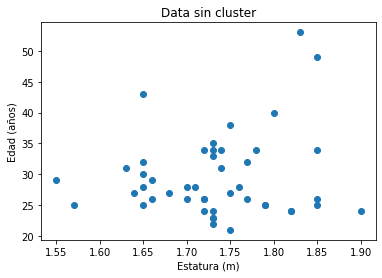

In [12]:
plt.scatter(df_train.iloc[:,0], df_train.iloc[:,1])
plt.xlabel("Estatura (m)")
plt.ylabel("Edad (años)")
plt.title("Data sin cluster")
plt.show()

## Función cálculo PDF multivariada normal


In [13]:
def Gaussian_Multivariate(df, mu, sigma):
  model = multivariate_normal(mean=mu, cov=sigma)
  return model.pdf(df)

## Función cálculo de parámetros de una distribución Gaussiana Mu y Sigma

In [14]:
def Gaussian_Estimation(df):
   mu = np.mean(df,axis=0)
   sigma = np.cov(df.T)
   return mu, sigma

## Función selección hiperparámetro Epsilon

In [15]:
def best_epsilon(p, anomaly):
  best_epsilon = 0
  best_f1_score = 0
  current_f1 = 0

  step_size = (max(p) - min(p)) / 1000
  epsilons = np.arange(min(p), max(p), step_size)

  for epsilon in np.nditer(epsilons):
    predictions = (p < epsilon)
    current_f1 = f1_score(anomaly.iloc[:,2], predictions, average = "binary")
    
    if (current_f1 > best_f1_score):
      best_f1_score = current_f1
      best_epsilon = epsilon
      
  return best_f1_score, best_epsilon

## Función revisión anomalías

In [67]:
def check_anomaly(probs, epsilon, df):
  df_anomaly = df.copy()
  anomalies = []
  for prob in probs:      
    if prob < epsilon:
      anomalies.append(True)
    else:
      anomalies.append(False)

  df_anomaly['Anomaly_check'] = anomalies

  return df_anomaly

## Parámetros Gaussianos

In [17]:
mu, sigma = Gaussian_Estimation(df_train)
print(mu)
print(sigma)

Estatura(metros)     1.732609
Edad(años)          29.521739
dtype: float64
[[5.67748792e-03 7.54975845e-02]
 [7.54975845e-02 4.50106280e+01]]


## PDF Train y Val dataset

In [18]:
train_p = Gaussian_Multivariate(df_train, mu, sigma)
train_p

array([0.23431945, 0.31009622, 0.22670016, 0.2208083 , 0.15095585,
       0.19969697, 0.14680711, 0.0858851 , 0.07053945, 0.1298267 ,
       0.19727557, 0.1734548 , 0.09782319, 0.15281049, 0.1734548 ,
       0.24569404, 0.26016966, 0.02912061, 0.18582358, 0.28445693,
       0.26924266, 0.0752    , 0.06213504, 0.09782319, 0.1431563 ,
       0.25247859, 0.0162055 , 0.28624323, 0.24029438, 0.16971073,
       0.27630645, 0.01364933, 0.25481827, 0.2765844 , 0.00051524,
       0.17421813, 0.22602604, 0.16831363, 0.19727557, 0.01561357,
       0.27630645, 0.11492684, 0.22529554, 0.00246508, 0.29927816,
       0.28606927])

In [19]:
val_p = Gaussian_Multivariate(df_cross_val, mu, sigma)
val_p

array([1.12582041e-01, 1.86911763e-01, 6.00555552e-02, 3.72938536e-02,
       1.47096262e-85, 0.00000000e+00])

In [32]:
df_true_anomaly = df_cross_val.copy()
df_true_anomaly['Anomaly'] = [False, False, False, False,  True,  True]

In [33]:
f1, epsilon = best_epsilon(val_p,df_true_anomaly)
print('Best F1 Score:', f1)
print('Best Epsilon: ', epsilon)

Best F1 Score: 1.0
Best Epsilon:  0.00018691176319452995


In [34]:
check_anomaly = check_anomaly(val_p, epsilon, df_true_anomaly)
check_anomaly

,Estatura(metros),Edad(años),Anomaly,Anomaly_check
0,1.82,25.0,False,False
1,1.80,27.0,False,False
2,1.60,31.0,False,False
3,1.60,35.0,False,False
4,0.25,2.5,True,True
5,175.10,2.5,True,True


## Graficar resultado

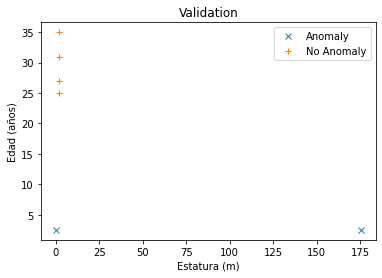

In [48]:
anomaly = check_anomaly[check_anomaly['Anomaly'] == True]
no_anomaly = check_anomaly[check_anomaly['Anomaly_check'] == False]

plt.plot(anomaly['Estatura(metros)'],anomaly['Edad(años)'],"x", label="Anomaly")
plt.plot(no_anomaly['Estatura(metros)'],no_anomaly['Edad(años)'],"+", label="No Anomaly")
plt.xlabel("Estatura (m)")
plt.ylabel("Edad (años)")
plt.title("Validation")
plt.legend()
plt.show()

## Dataset Test

In [49]:
test_p = Gaussian_Multivariate(df_test, mu, sigma)
test_p

array([0.16164905, 0.28329198, 0.23685512, 0.07591598, 0.        ,
       0.        ])

## Verificar anomalía Dataset Test

In [62]:
df_test

,Estatura(metros),Edad(años)
0,1.82,30.0
1,1.76,32.0
2,1.79,31.0
3,1.61,31.0
4,0.15,250.0
5,150.00,14.0


In [68]:
val_anomaly = check_anomaly(test_p, epsilon,df_test )
val_anomaly

,Estatura(metros),Edad(años),Anomaly_check
0,1.82,30.0,False
1,1.76,32.0,False
2,1.79,31.0,False
3,1.61,31.0,False
4,0.15,250.0,True
5,150.00,14.0,True


## Graficar resultado

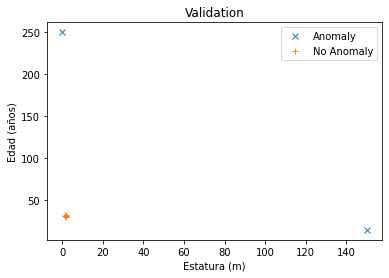

In [69]:
anomaly = val_anomaly[val_anomaly['Anomaly_check'] == True]
no_anomaly = val_anomaly[val_anomaly['Anomaly_check'] == False]

plt.plot(anomaly['Estatura(metros)'],anomaly['Edad(años)'],"x", label="Anomaly")
plt.plot(no_anomaly['Estatura(metros)'],no_anomaly['Edad(años)'],"+", label="No Anomaly")
plt.xlabel("Estatura (m)")
plt.ylabel("Edad (años)")
plt.title("Validation")
plt.legend()
plt.show()